# EMNLP 2022 (NLLP)
## Semantic Legal Searcher : Faster Natural Language-based Semantic Search for Case Law

## 0. Import

In [ ]:
! pip install transformers
! pip install -U sentence-transformers
! pip install sentencepiece
! pip install faiss-gpu
! pip install pytrends
! pip install funcy pickle5

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util

## 1. Legal Database (Original Korean Case Law)

In [5]:
# 1. Load Legal Dataset(Get Only Judicial precedent data)
df = pd.read_csv('./data/law_cases(20221020).csv')
df = df.dropna(how='any')
# 2. Make index for clustering
print(">> Judicial precedent data size : ",len(df))
df.head()

>> Judicial precedent data size :  62535


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm
1,지연이자청구,2015다223411,20170530.0,400101.0,"국가가 확정된 형사보상금의 지급을 지체하는 경우, 미지급 형사보상금에 대하여 지급...","헌법 제28조, 형사보상 및 명예회복에 관한 법률(이하 ‘형사보상법’이라고 한다) ...","【원고, 피상고인】 별지 원고 명단 기재와 같다. (소송대리인 동화법무법인 외 1인...",84878,8857,0.884545
3,손해배상(기)·매매대금반환,"2014다233176, 233183",20170530.0,400101.0,영국 계약법상 이행거절의 의미 및 이행거절의 의사를 표시했는지 판단하는 방법 / 당...,영국 계약법에서는 이행기 전 계약위반의 법리(doctrine of anticip...,"【원고(반소피고), 피상고인】 파산채무자 주식회사 21세기조선의 소송수계인 파산채무...",84876,3793,0.373030
4,숙박업영업신고증교부의무부작위위법확인,2017두34087,20170530.0,400107.0,숙박업을 하고자 하는 자가 법령이 정하는 시설과 설비를 갖추고 행정청에 신고를 ...,숙박업은 손님이 잠을 자고 머물 수 있도록 시설과 설비 등의 서비스를 제공하는 ...,"【원고, 상고인】 【피고, 피상고인】 속초시장【원심판결】 서울고법 2017. 1. ...",84875,7196,0.716768
5,손해배상(기),2017다211146,20170530.0,400101.0,새로운 청구를 심리하기 위하여 종전의 소송자료를 대부분 이용할 수 없고 별도의 증거...,민사소송법 제1조 제1항은 “법원은 소송절차가 공정하고 신속하며 경제적으로 진행되도...,"【원고, 상고인】 주식회사 메가럭 (소송대리인 법무법인(유한) 한동 담당변호사 고일...",84874,7832,0.781010
8,기타(금전),2016다275402,20170530.0,400101.0,"[1] 금전채무에 관하여 이행지체에 대비한 지연손해금 비율을 따로 약정한 경우, 민...",[1] 금전채무에 관하여 이행지체에 대비한 지연손해금 비율을 따로 약정한 경우에 이...,"【원고, 상고인】 현대건설 주식회사 (소송대리인 법무법인 가우 담당변호사 이경환 외...",84871,3410,0.334343


In [6]:
# 3. Text length measurement function
def text_len_plot(dataframe, col):
    """
    dataframe : DataFrame
    col : str(Column name)
    """
    dataframe['text_len'] = dataframe[col].apply(lambda words : len(words.split()))
    #dataframe['sent_len'] = dataframe[col].apply(lambda words : len(words.split(".")))
    mean_seq_len = np.round(dataframe['text_len'].mean() + dataframe['text_len'].std()).astype(int)
    #mean_sent_len = np.round(dataframe['sent_len'].mean() + dataframe['sent_len'].std()).astype(int)
    print(">> {} Average Text length : {}".format(col, mean_seq_len))
    print(">> {} Max Text length : {}".format(col, dataframe['text_len'].max()))
    print(">> {} Text words : {}".format(col, dataframe['text_len'].sum()))

    plt.figure(figsize=(12,6))
    sns.histplot(dataframe['text_len'], kde=True, color='royalblue', label='Text_length')
    plt.axvline(x=mean_seq_len, color='r', linestyle='--', label='max_length')
    plt.title('Text length'); plt.legend()
    plt.show()

>> judgment_issue Average Text length : 62
>> judgment_issue Max Text length : 611
>> judgment_issue Text words : 1917747


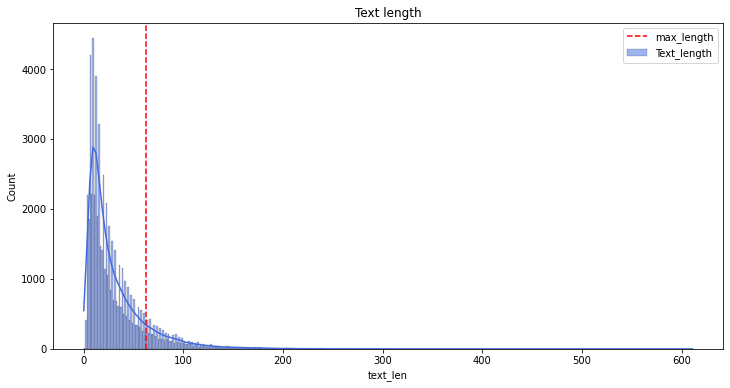

>> judgment_summary Average Text length : 214
>> judgment_summary Max Text length : 2849
>> judgment_summary Text words : 6577021


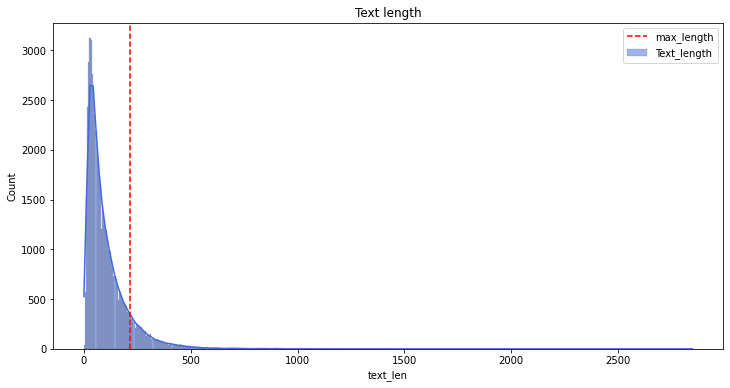

>> judgment_contents Average Text length : 1491
>> judgment_contents Max Text length : 37418
>> judgment_contents Text words : 42366443


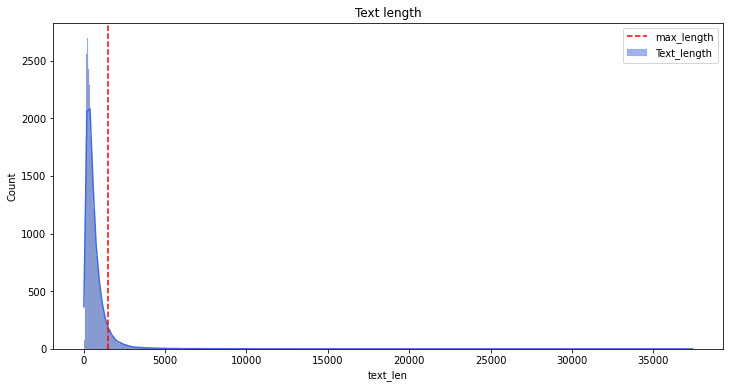

>> case_name Average Text length : 2
>> case_name Max Text length : 57
>> case_name Text words : 71717


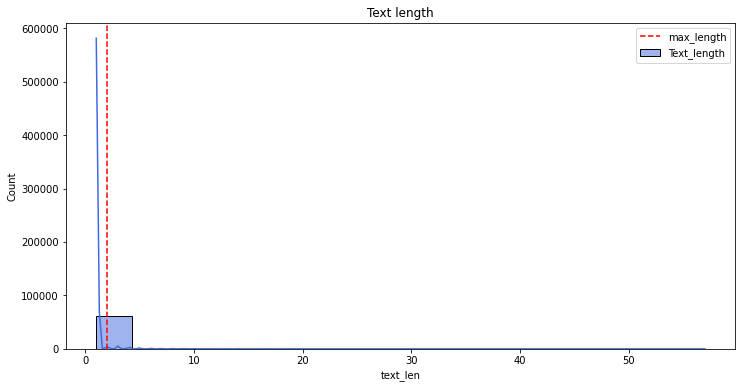

In [7]:
# 3. Text Length
# 3-1. Judgment_issue
text_len_plot(df, 'judgment_issue')
# 3-2. judgment_summary
text_len_plot(df, 'judgment_summary')
# 3-3. judgment_full-text
text_len_plot(df, 'judgment_contents')
# 3-4. case_name
text_len_plot(df, 'case_name')

## STEP 1 : Load Pre-Trained Language model

In [8]:
# Load supervised or unsupervised fine-tuned models
my_model = './output/nil_sts_tsdae-bert'

## STEP 2 : Parallel Clustering-based Topic Modeling

In [9]:
from models.parallel_topic_model import *

In [10]:
# 1.Obtain Semantic Legal Embedding
target_column = 'judgment_summary'

cluster = ParallelCluster(
    dataframe = df,
    tgt_col = target_column,
    model_name = my_model,
    use_sentence_bert = True
    )

Batches:   0%|          | 0/1955 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62535, 768)


In [11]:
# 2. Parallel Embedding Clustering
clusters, unclusters = cluster.parallel_cluster(
    clusters = None,
    threshold = 0.78,
    page_size = 2500,
    iterations = 15
    )

=== Iteration 1 / 15 ===


>> Number of Total Clusters :  345
>> Percentage clusted Doc Embeddings : 10.31%


=== Iteration 2 / 15 ===


>> Number of Total Clusters :  613
>> Percentage clusted Doc Embeddings : 15.56%


=== Iteration 3 / 15 ===


>> Number of Total Clusters :  799
>> Percentage clusted Doc Embeddings : 18.29%


=== Iteration 4 / 15 ===


>> Number of Total Clusters :  922
>> Percentage clusted Doc Embeddings : 19.82%


=== Iteration 5 / 15 ===


>> Number of Total Clusters :  1031
>> Percentage clusted Doc Embeddings : 21.11%


=== Iteration 6 / 15 ===


>> Number of Total Clusters :  1123
>> Percentage clusted Doc Embeddings : 22.05%


=== Iteration 7 / 15 ===


>> Number of Total Clusters :  1205
>> Percentage clusted Doc Embeddings : 22.93%


=== Iteration 8 / 15 ===


>> Number of Total Clusters :  1276
>> Percentage clusted Doc Embeddings : 23.75%


=== Iteration 9 / 15 ===


>> Number of Total Clusters :  1349
>> Percentage clusted Doc Embeddings : 24.49%


=== I

In [12]:
# 3. Stack : Stack the clustered results in order of cluster size
col_list = ['case_name', 'case_number', 'date', 'case_code',
            'judgment_issue', 'judgment_summary', 'judgment_contents',
            'case_id', 'case_hits', 'case_hits_norm']

new_df = cluster.cluster_stack(
    col_list = col_list,
    clusters = clusters,
    unclusters = unclusters
    )

# 4. Topic Modeling : Extract Latent Topics (or Keywords)
top_n_words = cluster.extract_top_n_words_per_topic(
    dataframe = new_df,
    n = 20,
    en = False
    )

new_df['Topic_Modeling'] = [top_n_words[i] for i in new_df['Topic'].values]

new_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['못하다', '아니다', '안된다', '않고', '않기', '없고', '하기'] not in stop_words.
  % sorted(inconsistent)
/content/drive/MyDrive/NLLP_2022/models/parallel_topic_model.py:400: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm,Topic,Topic_Modeling
711,부당해고구제재심판정취소,2021두45114,20211028.0,400107.0,[1] 근로자에게 이미 형성된 갱신에 대한 정당한 기대권이 있는데도 사용자가 이를 ...,[1] 근로자에게 이미 형성된 갱신에 대한 정당한 기대권이 있는데도 사용자가 이를 ...,"【원고, 피상고인】 주식회사 청원종합관리 (소송대리인 변호사 김의택)【피고, 상고인...",84168,1917,0.183535,0,"[(근로자의, 0.023030334973188394), (사용자가, 0.023023..."
1160,부당해고구제재심판정취소,2016두64876,20210729.0,400107.0,[1] 부당해고 구제신청에 관한 중앙노동위원회의 명령 또는 결정의 취소를 구하는 소...,[1] 부당해고 구제신청에 관한 중앙노동위원회의 명령 또는 결정의 취소를 구하는 소...,"【원고, 피상고인】 일진전기 주식회사 (소송대리인 법무법인(유한) 태평양 담당변호사...",83719,5006,0.495556,0,"[(근로자의, 0.023030334973188394), (사용자가, 0.023023..."
1388,"임금[업적연봉 등이 통상임금에 해당되는지, 업적연봉을 통상임금에 포함하여 계산한 추...",2017다52712,20210610.0,400101.0,[1] 통상임금에서 제외하기로 하는 노사합의가 없는 임금에 대해서 근로자가 이를 통...,[1] 단체협약 등 노사합의의 내용이 근로기준법의 강행규정을 위반하여 무효인 경우에...,"【원고, 피상고인】 별지 원고 명단 기재와 같다. (소송대리인 법무법인 정세 담당변...",83491,7971,0.795051,0,"[(근로자의, 0.023030334973188394), (사용자가, 0.023023..."
1687,해고무효확인[근로자에 대한 계약종료통지서에 해고사유가 전혀 기재되어 있지 않았던 사건],2017다226605,20210225.0,400101.0,"[1] 사용자가 해고를 서면으로 통지하면서 해고사유를 전혀 기재하지 않은 경우, 근...",[1] 근로기준법 제27조는 사용자가 근로자를 해고하려면 해고사유와 해고시기를 서면...,"[원고, 상고인] 원고 (소송대리인 법무법인 어울림 담당변호사 구은미 외 2인)[피...",83192,9805,0.980303,0,"[(근로자의, 0.023030334973188394), (사용자가, 0.023023..."
2274,부당해고구제재심판정취소,2018두34480,20200820.0,400107.0,"[1] 근로자가 소속 직장의 대표자, 관리자나 동료 등을 수사기관 등에 고소·고...",[1] 근로자가 뚜렷한 자료도 없이 사실을 허위로 기재하거나 왜곡하여 소속 직장...,"【원고, 피상고인】 울산과학기술원 (소송대리인 변호사 주완 외 1인)【피고, 상고인...",82605,7935,0.791414,0,"[(근로자의, 0.023030334973188394), (사용자가, 0.023023..."


In [13]:
# 5. Save the Parallel Clusted Dataset 
new_df.to_csv("./data/clusted_df.csv", sep=',', na_rep="NaN")

## STEP 3. Semantic law case search 
    - Measure relevance between input query and clustered documents embeddings.

In [14]:
from models.semantic_law_search import *

In [15]:
# 1. Load Clustered DataFrame
new_df = pd.read_csv('./data/clusted_df.csv')

# 2. Obtain clustered documents embeddings from PLMs(KoLawBERT models)
law_bert = KoLawBERT(
    dataframe = new_df,
    tgt_col = 'judgment_summary',
    model_name = my_model,
    use_sentence_bert = True,
    cluster = True
    )

Batches:   0%|          | 0/1955 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62535, 768)


In [16]:
# 3. Build the Index
# 3-1.(Strategy 1) : Calculate Vector Similarity with All text embeddings
index_1 = law_bert.all_relevant_embedding()

# 3-2.(Strategy 2) : Calculate Vector Similarity with Centroid of embeddings
index_2 = law_bert.centroid_relevant_embedding(nlist = 200, nprobe = 6)

In [17]:
# 4. Search

### Enter user's query ###
# "(English) My car collided with a vehicle in the next lane while trying to avoid another vehicle changing from lane 1 to 2."
my_query = "1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다."

# 4-1. Search the Law cases(Strategy 1)
original_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_1,
    print_results = True,
    )


 === Calculate run time : 85.3393 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.004895302660644755), ('개정되기', 0.004382647246504746), ('규정하고', 0.0035529523642787264), ('12', 0.0034832896879512174), ('규정에', 0.0034074164301419376), ('이는', 0.0031634985853913142), ('당해', 0.003131939093931867), ('있어서', 0.0031097282438917405), ('보아야', 0.0031067761367798152), ('피고인이', 0.0031015415623067166), ('제2항', 0.0030721372506215643), ('이하', 0.0030198765590259916), ('이에', 0.0030109992651397833), ('받은', 0.0029876245643519015), ('사안에서', 0.0029864241737815457), ('사정이', 0.0029846692854051983), ('없고', 0.0029701735457396197), ('없다고', 0.0029700670340868695), ('특별한', 0.0029569398392564595), ('없이', 0.002949390021037917)] 
 | Date : 20201230.0 | Judgment Issue : [1] 도로교통법 제2조 제26호에서 규정하는 ‘운전’의 의미[2] 피고인이 시동을 걸지 못하고 제동장치를 조작하다 차량이 후진하면서 추돌 사고를 야기하여 특정범죄 가중처벌

In [18]:
# 4-2. Search the Law cases(Strategy 2 : More Faster)
fast_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_2,
    print_results = True,
    )


 === Calculate run time : 16.633 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.004895302660644755), ('개정되기', 0.004382647246504746), ('규정하고', 0.0035529523642787264), ('12', 0.0034832896879512174), ('규정에', 0.0034074164301419376), ('이는', 0.0031634985853913142), ('당해', 0.003131939093931867), ('있어서', 0.0031097282438917405), ('보아야', 0.0031067761367798152), ('피고인이', 0.0031015415623067166), ('제2항', 0.0030721372506215643), ('이하', 0.0030198765590259916), ('이에', 0.0030109992651397833), ('받은', 0.0029876245643519015), ('사안에서', 0.0029864241737815457), ('사정이', 0.0029846692854051983), ('없고', 0.0029701735457396197), ('없다고', 0.0029700670340868695), ('특별한', 0.0029569398392564595), ('없이', 0.002949390021037917)] 
 | Date : 20201230.0 | Judgment Issue : [1] 도로교통법 제2조 제26호에서 규정하는 ‘운전’의 의미[2] 피고인이 시동을 걸지 못하고 제동장치를 조작하다 차량이 후진하면서 추돌 사고를 야기하여 특정범죄 가중처벌 

## STEP 4. Dynamic Post-filtering

In [19]:
from models.dynamic_post_filtering import *

### 4-1. Popularity-Based Filtering

In [20]:
p_outputs = sorted(original_outputs, key=lambda x: x['case_hits'], reverse = True)

print("\n  ========== <<  Popularity-based Filtering (Hits)  >> ========== \n")
for i, out in enumerate(p_outputs):
    #print("\n === Law Cases ===")
    print("\n   Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))


  ========== <<  Popularity-based Filtering (Hits)  >> ========== 


   Top 1 - Case name (Number) : 교통사고처리특례법위반 (91도1746)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.004895302660644755), ('개정되기', 0.004382647246504746), ('규정하고', 0.0035529523642787264), ('12', 0.0034832896879512174), ('규정에', 0.0034074164301419376), ('이는', 0.0031634985853913142), ('당해', 0.003131939093931867), ('있어서', 0.0031097282438917405), ('보아야', 0.0031067761367798152), ('피고인이', 0.0031015415623067166), ('제2항', 0.0030721372506215643), ('이하', 0.0030198765590259916), ('이에', 0.0030109992651397833), ('받은', 0.0029876245643519015), ('사안에서', 0.0029864241737815457), ('사정이', 0.0029846692854051983), ('없고', 0.0029701735457396197), ('없다고', 0.0029700670340868695), ('특별한', 0.0029569398392564595), ('없이', 0.002949390021037917)] 
 | Date : 19910910.0 | Judgment Issue :  방향지시등을 켜지 않은 채 2차선 도로의 1차선상에서 우회전하는 화물차와 같은 방향의 2차선상을 운행하는 승용차가 충돌하여 발생한 교통사고처리특례법위반사건에 있어서 승용차 운전자의 과실을 인정하기 어렵다고 한 사례 
 | Judgment Summary :  방향지시등을

### 4-2. User-Based Filtering

In [21]:
# 1. Load User cases hits data
user_rating = pd.read_csv('./data/user_views.csv')
view_df = new_df[['case_id', 'case_name', 'judgment_issue', 'judgment_summary', 'case_hits', 'case_hits_norm']]
user_df = pd.merge(user_rating, view_df, on = 'case_id')
print(">> Merge dataframe size : ", len(user_df))
user_df.head()

>> Merge dataframe size :  370456


,user_id,case_id,user_hits,case_name,judgment_issue,judgment_summary,case_hits,case_hits_norm
0,lawyer_0,42097,25,구상금,[1] 공동불법행위자 간의 부담 부분과 구상권[2] 공동불법행위자 중 1인이 다른 ...,[1] 공동불법행위자는 채권자에 대한 관계에서는 연대책임(부진정연대채무)을 지되...,514,0.041818
1,lawyer_10,42097,40,구상금,[1] 공동불법행위자 간의 부담 부분과 구상권[2] 공동불법행위자 중 1인이 다른 ...,[1] 공동불법행위자는 채권자에 대한 관계에서는 연대책임(부진정연대채무)을 지되...,514,0.041818
2,lawyer_16,42097,84,구상금,[1] 공동불법행위자 간의 부담 부분과 구상권[2] 공동불법행위자 중 1인이 다른 ...,[1] 공동불법행위자는 채권자에 대한 관계에서는 연대책임(부진정연대채무)을 지되...,514,0.041818
3,lawyer_23,42097,93,구상금,[1] 공동불법행위자 간의 부담 부분과 구상권[2] 공동불법행위자 중 1인이 다른 ...,[1] 공동불법행위자는 채권자에 대한 관계에서는 연대책임(부진정연대채무)을 지되...,514,0.041818
4,lawyer_24,42097,61,구상금,[1] 공동불법행위자 간의 부담 부분과 구상권[2] 공동불법행위자 중 1인이 다른 ...,[1] 공동불법행위자는 채권자에 대한 관계에서는 연대책임(부진정연대채무)을 지되...,514,0.041818


In [22]:
# 2. Make Law case and User Interaction table
cf_preds_df = interaction_table(user_df)

# 3. If User Id is "laywer_10" 
user_outputs = user_based_sementic_search(
    cf_dataframe = cf_preds_df,
    view_dataframe = view_df,
    user_id = 10,
    my_model = law_bert,
    my_query = my_query,
    index_kind = index_1
    )

# 4. Sorting by scaled ratings
user_outputs = sorted(user_outputs, key = lambda x : x['scaled_rating'], reverse = True)
user_outputs = user_outputs[:10]

print("\n  ========== <<  User-based Filtering  >> ==========  \n")
for i, out in enumerate(user_outputs):
    #print("\n === Law Cases ===")
    print("\n   Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))


 >> Original Matrix shape :  (50, 61646)

 >> Total User Ids :  50

 >> Interaction Matrix (Law Cases x User) : (61646, 50)

 === Calculate run time : 82.0043 ms === 


  ========== <<  User-based Filtering  >> ==========  


   Top 1 - Case name (Number) : 교통사고처리특례법위반 (2001도5005)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.004895302660644755), ('개정되기', 0.004382647246504746), ('규정하고', 0.0035529523642787264), ('12', 0.0034832896879512174), ('규정에', 0.0034074164301419376), ('이는', 0.0031634985853913142), ('당해', 0.003131939093931867), ('있어서', 0.0031097282438917405), ('보아야', 0.0031067761367798152), ('피고인이', 0.0031015415623067166), ('제2항', 0.0030721372506215643), ('이하', 0.0030198765590259916), ('이에', 0.0030109992651397833), ('받은', 0.0029876245643519015), ('사안에서', 0.0029864241737815457), ('사정이', 0.0029846692854051983), ('없고', 0.0029701735457396197), ('없다고', 0.0029700670340868695), ('특별한', 0.0029569398392564595), ('없이', 0.002949390021037917)] 
 | Date : 20011211.0 | Judgment 

### 4-3. Online-based Filtering

In [23]:
# 1. Type of Law Cases (Based onf Korea and United state courts)
genre = ['Criminal cases',
         'Civil cases',
         'Family cases',
         'Bankrupty',
         'Marriage Dissolution',
         'Paternity',
         'Child Custody',
         'Domestic Violence cases',
         'Name Changes',
         'Guardianship',
         'Parental Rights',
         'Adoptions',
         'Juvenile cases',
         'Fines cases',
         'Community service cases',
         'Probation cases',
         'Prision',
         'Tort claims',
         'Breach of contract claims',
         'Equitable claims',
         'Landlord and tenant']

Search date range : ['2022-10-04 2022-10-20']

 === Calculate run time : 75.9099 ms === 


  ========== <<  Online-based Filtering  >> ==========  


   Top 1 - Case name (Number) : 교통사고처리특례법위반 (88도1678)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.004895302660644755), ('개정되기', 0.004382647246504746), ('규정하고', 0.0035529523642787264), ('12', 0.0034832896879512174), ('규정에', 0.0034074164301419376), ('이는', 0.0031634985853913142), ('당해', 0.003131939093931867), ('있어서', 0.0031097282438917405), ('보아야', 0.0031067761367798152), ('피고인이', 0.0031015415623067166), ('제2항', 0.0030721372506215643), ('이하', 0.0030198765590259916), ('이에', 0.0030109992651397833), ('받은', 0.0029876245643519015), ('사안에서', 0.0029864241737815457), ('사정이', 0.0029846692854051983), ('없고', 0.0029701735457396197), ('없다고', 0.0029700670340868695), ('특별한', 0.0029569398392564595), ('없이', 0.002949390021037917)] 
 | Date : 19890411.0 | Judgment Issue :  중앙선이 설치된 도로에서 다른 차량운행자의 신뢰와 어긋난 운행을 한 경우 
          교통사고처리특례법 제3조 제2항 

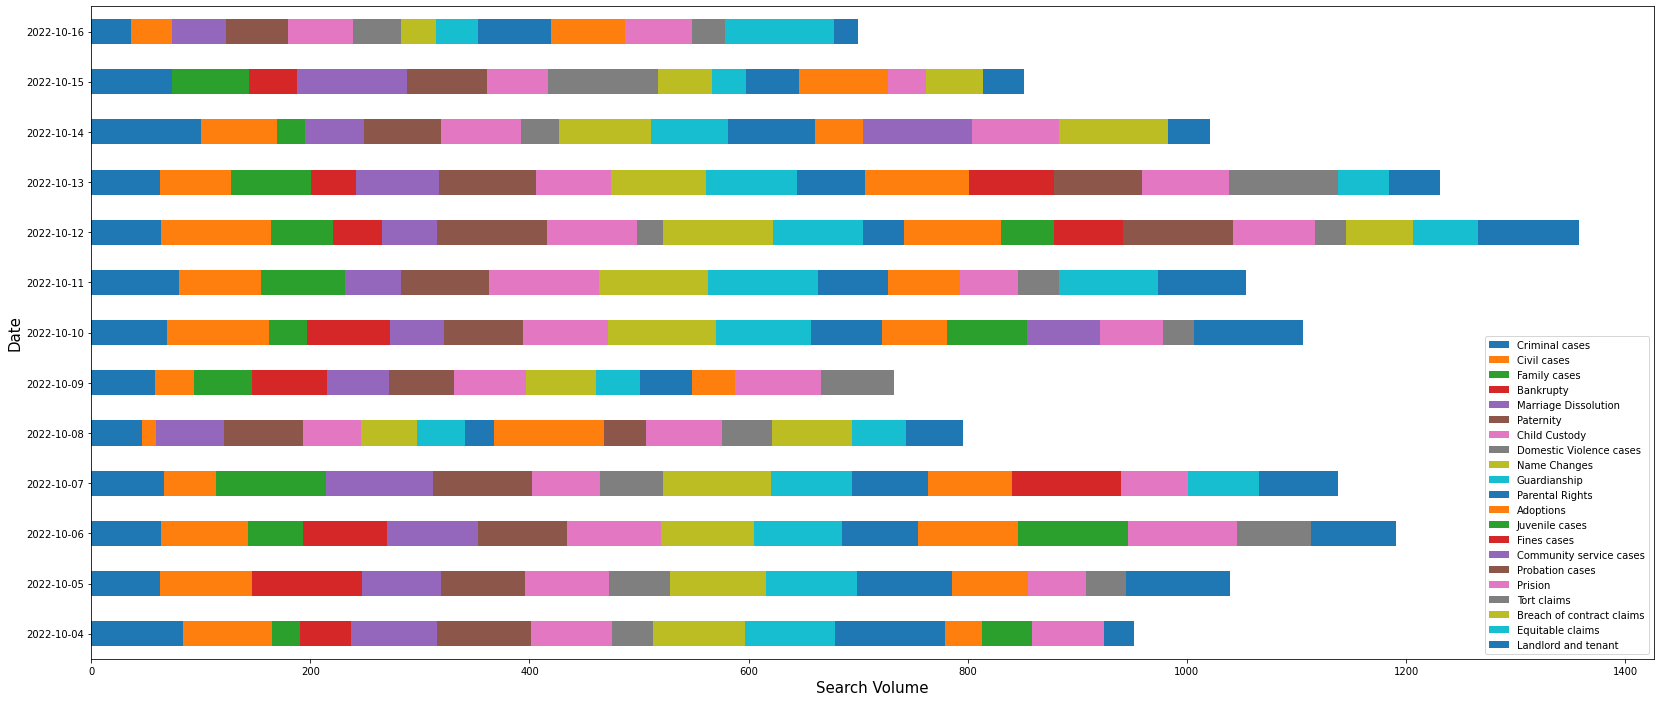

In [24]:
# 2. Encoding and make search vector
_, items = keyword_encoding(genre, law_bert)
search_encoded_vector = online_search_vector(genre, items)

# 3. Get original Semantic Embeddings
semantic_outputs, _ = law_bert.search(user_query = my_query, top_k = 10, index = index_1)
candidate_plots = [x['judgment_summary'] for x in semantic_outputs]
embeddings = law_bert.model.encode(candidate_plots)

# 4. Compute Cosine-sim for each sentence with search_vector
cosine_scores = util.pytorch_cos_sim(search_encoded_vector, embeddings)
for (i, score) in zip(semantic_outputs, cosine_scores.numpy()[0]):
    i['search_score'] = score

# 5. Sorting by search_score
online_outputs = sorted(semantic_outputs, key=lambda x: x['search_score'], reverse = True)

print("\n  ========== <<  Online-based Filtering  >> ==========  \n")
for i, out in enumerate(online_outputs):
   #print("\n === Law Cases ===")
   print("\n   Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

### 4-4. Dynamic Poist-filtering result

In [25]:
print("\n")
print("\n >> Write your case :", my_query)
print("\n")

# Case name (Case number) : Judgment issue (cluster_name) 
results = pd.DataFrame()
results['Only Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in original_outputs]
results['Popularity-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in p_outputs]
results['User-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in user_outputs]
results['Online-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in online_outputs]
results




 >> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.




,Only Semantic Search,Popularity-based Semantic Search,User-based Semantic Search,Online-based Semantic Search
0,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,교통사고처리특례법위반 (2001도5005) : [1] 선행차량에 이어 피고인 운전 ...,교통사고처리특례법위반 (88도1678) : 중앙선이 설치된 도로에서 다른 차량운행...
1,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,손해배상(자) (90다13635) : 반대차선 건너 골목에서 반대차선의 바깥차선쪽으...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...
2,구상금 (99다22168) : 교통정리가 행하여지지 않는 교차로에서 좌회전하기 위하...,손해배상(자) (96다30823) : [1] \n 도로교통법 제17...,교통사고처리특례법위반 (84도2134) : 교통사고처리특례법 제3조 제2항 단서 제...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...
3,손해배상(자) (96다30823) : [1] \n 도로교통법 제17...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,"교통사고처리특례법위반,도로교통법위반 (87도884) : 교통사고처리특례법 제3조 제...",손해배상(자) (96다30823) : [1] \n 도로교통법 제17...
4,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...,특정범죄가중처벌등에관한법률위반(도주차량)(인정된 죄명 : 교통사고처리특례법위반)·도...,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...
5,특정범죄가중처벌등에관한법률위반(도주차량) (93도2562) : 일방통행 도로를 역...,특정범죄가중처벌등에관한법률위반(도주차량) (93도2562) : 일방통행 도로를 역...,구상금 (97다47620) : 신호등이 있는 교차로에서 다른 방향의 교통상황을 살피...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...
6,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...,구상금 (99다22168) : 교통정리가 행하여지지 않는 교차로에서 좌회전하기 위하...,공직선거및선거부정방지법위반 (99노16) : 사고 장소 부근을 전후한 약 10...,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...
7,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,손해배상 (86다카166) : 차량끼리의 충돌로 인한 교통사고에 있어서 쌍방과실의...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,특정범죄가중처벌등에관한법률위반(도주차량) (93도2562) : 일방통행 도로를 역...
8,교통사고처리특례법위반 (88도1678) : 중앙선이 설치된 도로에서 다른 차량운행...,교통사고처리특례법위반 (88도1678) : 중앙선이 설치된 도로에서 다른 차량운행...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,손해배상 (86다카166) : 차량끼리의 충돌로 인한 교통사고에 있어서 쌍방과실의...
9,손해배상 (86다카166) : 차량끼리의 충돌로 인한 교통사고에 있어서 쌍방과실의...,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...,업무상과실치상 (82도3222) : 안전거리를 확보치 않은 차가 뒷차의 충격으로 ...,구상금 (99다22168) : 교통정리가 행하여지지 않는 교차로에서 좌회전하기 위하...
